In [616]:
import numpy as np
from matplotlib import pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from os.path import exists
import time
import torch.nn.functional as F
import math
import matplotlib as mpl


In [617]:
pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [618]:
####### View data ###########

def plot_multiple_samples(data,labels):
    m = data.shape[0]
    fig, axes = plt.subplots(ncols = m,sharex=False, sharey=True, figsize=(10, 4))
    for i in range(m):
        label = int(labels[i])
        axes[i].set_title(label)
        axes[i].imshow(data[i,0,:,:], cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    plt.show()

def plot_multiple_samples_incorrect_label(data):
    m = len(data)
    fig, axes = plt.subplots(ncols = m,sharex=False, sharey=True, figsize=(10, 4))
    for i in range(m):
#        data[i,0,:,:], number, modelOutput])
        label = 'Truth: ' + str(data[i][1]) + '\nModel label: ' + str(data[i][2])
        axes[i].set_title(label)
        axes[i].imshow(data[i][0], cmap='gray')
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    plt.show()

In [619]:
########## data import and prep ###########

import idx2numpy

def import_data(imageFile,labelsFile):
    data = idx2numpy.convert_from_file(imageFile)
    # arr is a np.ndarray type of object of shape (60000, 28, 28)
    labels = idx2numpy.convert_from_file(labelsFile)
    # labels is a np.ndarray type of object of shape (60000, )
    data = (torch.tensor(data).float() - 128)/128
    #normalises the data to the interval [-1,1]
    labels = torch.tensor(labels).float()

    dataShape = torch.reshape(data,(-1,1,28,28))
    # We reshape to allow for a channel "1" which makes working with the convolution functions later easier
    return dataShape, labels
    

def prepare_label_array(labels):
    # input is an array of the digits, output is an array of 10x1 with a "1" at the correct position
    m = list(labels.shape)[0]

    labelTensor = torch.zeros(size=(m,10))
    for i in range(m):
        l = int(labels[i].item())
        labelTensor[i,l] = 1

    return labelTensor

def generate_random_image_data(n):

    imageArray = np.random.randint(0,256,size = (n,1,28,28))

    return torch.tensor(imageArray).float()


In [620]:
############ Test model ############

def run_test_set(model,testFiles,numberToPlot,nTest,device,printOutput):
    data, numbers = import_data(testFiles[0],testFiles[1])
    labels = prepare_label_array(numbers)
    data = data.to(device)
    numbers = numbers.to(device)
    testModelOutputs = model.forward(data[0:nTest,:,:,:])
    m,n = testModelOutputs.shape
    nSample = 0
    nTrue = 0
    incorrectData = []
    incorrectModelOutputs = []
    for i in range(m):
        nSample += 1
        modelOutput = torch.argmax(testModelOutputs[i]).item()
        number = int(numbers[i].item())
        if number == modelOutput:
            outcome = 'Correct'
            nTrue += 1
        else:
            outcome = 'Incorrect'
            incorrectData.append([data[i,0,:,:].cpu(), number, modelOutput])
            incorrectModelOutputs.append(testModelOutputs[i])
 
    percentCorrect = round(100.0*nTrue/nSample,1)

    if printOutput:
      print('In the test set ' + str(percentCorrect) + '% were correctly classified.')

    if numberToPlot != 0 and printOutput:
        if len(incorrectData) >numberToPlot:
            randPlots = numberToPlot
        else:
            randPlots = len(incorrectData)
        dataSubset = random.sample(incorrectData,randPlots)
        plot_multiple_samples_incorrect_label(dataSubset)
    return percentCorrect


In [621]:
from torch.nn.modules.batchnorm import BatchNorm2d
########## Model ##########

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = self.conv_block(1,10,3)
        self.conv2 = self.conv_block(10,20,2,1,2)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def conv_block(self, inputChannel, outputChannel, kernelSize, stride = 1, padding = 1):
      return nn.Sequential(
          nn.Conv2d(inputChannel,outputChannel,kernelSize,stride,padding),
          nn.MaxPool2d(3),
          nn.BatchNorm2d(outputChannel),
          nn.ReLU(0.2)
      )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = self.relu(x)

        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [622]:
############# Backprop #############

def run_backpropogation_optimisation(device,model,X,y,epochs,learningRate,iterNumbers,
                                     printSubset,losses,nBatch,loss_function,dataloader,percentCorrect,plots):
    numberBatch = math.floor(X.shape[0]/nBatch)
    start = time.time()
    n = iterNumbers[-1]
    for epoch in range(epochs):
      epochStart = time.time()
      for i, data in enumerate(dataloader, 0):
        n = n+1
        iterNumbers.append(n)
        optimiser.zero_grad()
        yPrediction = model(data[0])
        loss = loss_function(yPrediction, data[1])
        loss.backward()
        optimiser.step()
        losses.append(loss.item())

        #if i % 20 == 0:
          # This is optional to see how decreasing error feeds into correct classification
         # percentCorrect.append([n,run_test_set(model,testFiles,plotNumberIncorrectSubset,nTest,device,False)])

      end = time.time()
      print('Epoch [' + str(epoch+1) + '/' + str(epochs) + '] training time: ' + str(round(end - start,2)) + 
            's at a learning rate of ' + str(learningRate) + ' with a final loss of ' + str(round(loss.item(),3)))
      if epoch % 10 == 0 and plots:
        percentCorrect.append([n,run_test_set(model,testFiles,plotNumberIncorrectSubset,nTest,device,True)])
    return model, losses, optimiser, iterNumbers,percentCorrect

In [623]:
def load_model(model,optimiser,modelPath):

  if exists(modelPath):
    checkpoint = torch.load(modelPath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
    initialEpoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print('Loaded model at ' + modelPath)
  else:
    print('No file found')

  return model,optimiser


In [624]:
fileFolder = '/content/drive/MyDrive/Colab Notebooks/train_classifier'

trainingFiles = [fileFolder + '/train-images-idx3-ubyte',fileFolder + '/train-labels-idx1-ubyte']
testFiles = [fileFolder + '/train-images-idx3-ubyte',fileFolder + '/train-labels-idx1-ubyte']
modelPath = fileFolder + '/classifier.pt'
# header    

plotRandomData = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

data,numbers = import_data(trainingFiles[0],trainingFiles[1])
labels = prepare_label_array(numbers)
data = data.to(device)
labels = labels.to(device)
if plotRandomData:
    n = np.random.randint(0,59999,4)
    plot_multiple_samples(data,numbers,n)

#either load the model in the file or make a new one
model = Classifier().to(device)

loss_function = nn.CrossEntropyLoss()
losses = []
iterNumbers = [0]
percentCorrect = []
dataset = TensorDataset( Tensor(data), Tensor(labels) )



Using cuda device


In [625]:
loadModel = False
saveModel = True
# set 0 to not plot any. Otherwise plot n incorrectly labelled items
plotNumberIncorrectSubset = 6
epochs = 100
printSubsets = 10 # how often you output model progress
learningRate = 0.0005
nTrain = 60000
nTest = 10000
nBatch = 128

optimiser = torch.optim.Adam(model.parameters(), lr=learningRate)
dataloader = DataLoader(dataset, batch_size= nBatch)


Epoch [1/100] training time: 2.08s at a learning rate of 0.0005 with a final loss of 0.242
In the test set 94.7% were correctly classified.


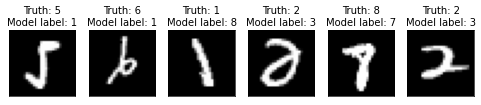

Epoch [2/100] training time: 6.13s at a learning rate of 0.0005 with a final loss of 0.233
Epoch [3/100] training time: 9.91s at a learning rate of 0.0005 with a final loss of 0.206
Epoch [4/100] training time: 13.51s at a learning rate of 0.0005 with a final loss of 0.179
Epoch [5/100] training time: 16.75s at a learning rate of 0.0005 with a final loss of 0.159
Epoch [6/100] training time: 18.61s at a learning rate of 0.0005 with a final loss of 0.176
Epoch [7/100] training time: 20.48s at a learning rate of 0.0005 with a final loss of 0.215
Epoch [8/100] training time: 22.33s at a learning rate of 0.0005 with a final loss of 0.187
Epoch [9/100] training time: 24.18s at a learning rate of 0.0005 with a final loss of 0.249
Epoch [10/100] training time: 26.04s at a learning rate of 0.0005 with a final loss of 0.253
Epoch [11/100] training time: 27.91s at a learning rate of 0.0005 with a final loss of 0.156
In the test set 98.5% were correctly classified.


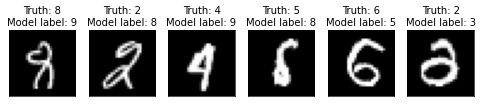

Epoch [12/100] training time: 31.19s at a learning rate of 0.0005 with a final loss of 0.226
Epoch [13/100] training time: 33.01s at a learning rate of 0.0005 with a final loss of 0.202
Epoch [14/100] training time: 34.84s at a learning rate of 0.0005 with a final loss of 0.159
Epoch [15/100] training time: 36.66s at a learning rate of 0.0005 with a final loss of 0.155
Epoch [16/100] training time: 38.65s at a learning rate of 0.0005 with a final loss of 0.217
Epoch [17/100] training time: 42.42s at a learning rate of 0.0005 with a final loss of 0.182
Epoch [18/100] training time: 46.37s at a learning rate of 0.0005 with a final loss of 0.183
Epoch [19/100] training time: 49.18s at a learning rate of 0.0005 with a final loss of 0.189
Epoch [20/100] training time: 51.05s at a learning rate of 0.0005 with a final loss of 0.176
Epoch [21/100] training time: 52.89s at a learning rate of 0.0005 with a final loss of 0.169
In the test set 99.0% were correctly classified.


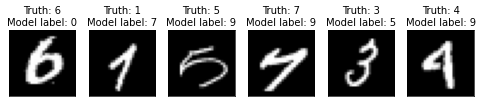

Epoch [22/100] training time: 56.11s at a learning rate of 0.0005 with a final loss of 0.166
Epoch [23/100] training time: 57.97s at a learning rate of 0.0005 with a final loss of 0.123
Epoch [24/100] training time: 59.82s at a learning rate of 0.0005 with a final loss of 0.112
Epoch [25/100] training time: 61.68s at a learning rate of 0.0005 with a final loss of 0.139
Epoch [26/100] training time: 63.51s at a learning rate of 0.0005 with a final loss of 0.147
Epoch [27/100] training time: 65.33s at a learning rate of 0.0005 with a final loss of 0.151
Epoch [28/100] training time: 67.15s at a learning rate of 0.0005 with a final loss of 0.107
Epoch [29/100] training time: 68.98s at a learning rate of 0.0005 with a final loss of 0.106
Epoch [30/100] training time: 70.8s at a learning rate of 0.0005 with a final loss of 0.135
Epoch [31/100] training time: 72.64s at a learning rate of 0.0005 with a final loss of 0.106
In the test set 99.3% were correctly classified.


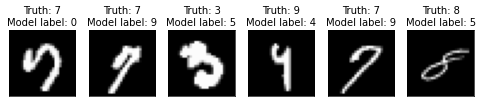

Epoch [32/100] training time: 75.93s at a learning rate of 0.0005 with a final loss of 0.075
Epoch [33/100] training time: 77.76s at a learning rate of 0.0005 with a final loss of 0.096
Epoch [34/100] training time: 79.6s at a learning rate of 0.0005 with a final loss of 0.124
Epoch [35/100] training time: 81.44s at a learning rate of 0.0005 with a final loss of 0.109
Epoch [36/100] training time: 83.27s at a learning rate of 0.0005 with a final loss of 0.11
Epoch [37/100] training time: 85.12s at a learning rate of 0.0005 with a final loss of 0.084
Epoch [38/100] training time: 86.95s at a learning rate of 0.0005 with a final loss of 0.054
Epoch [39/100] training time: 88.78s at a learning rate of 0.0005 with a final loss of 0.065
Epoch [40/100] training time: 90.65s at a learning rate of 0.0005 with a final loss of 0.089
Epoch [41/100] training time: 92.54s at a learning rate of 0.0005 with a final loss of 0.094
In the test set 99.3% were correctly classified.


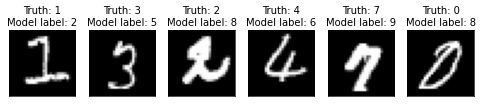

Epoch [42/100] training time: 95.71s at a learning rate of 0.0005 with a final loss of 0.06
Epoch [43/100] training time: 97.57s at a learning rate of 0.0005 with a final loss of 0.036
Epoch [44/100] training time: 100.37s at a learning rate of 0.0005 with a final loss of 0.108
Epoch [45/100] training time: 102.22s at a learning rate of 0.0005 with a final loss of 0.021
Epoch [46/100] training time: 104.07s at a learning rate of 0.0005 with a final loss of 0.033
Epoch [47/100] training time: 105.94s at a learning rate of 0.0005 with a final loss of 0.076
Epoch [48/100] training time: 107.97s at a learning rate of 0.0005 with a final loss of 0.035
Epoch [49/100] training time: 110.55s at a learning rate of 0.0005 with a final loss of 0.049
Epoch [50/100] training time: 112.37s at a learning rate of 0.0005 with a final loss of 0.014
Epoch [51/100] training time: 114.79s at a learning rate of 0.0005 with a final loss of 0.017
In the test set 99.4% were correctly classified.


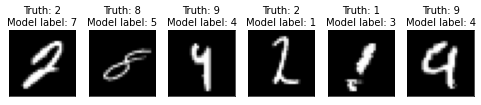

Epoch [52/100] training time: 118.18s at a learning rate of 0.0005 with a final loss of 0.008
Epoch [53/100] training time: 120.05s at a learning rate of 0.0005 with a final loss of 0.003
Epoch [54/100] training time: 121.92s at a learning rate of 0.0005 with a final loss of 0.036
Epoch [55/100] training time: 123.77s at a learning rate of 0.0005 with a final loss of 0.052
Epoch [56/100] training time: 125.63s at a learning rate of 0.0005 with a final loss of 0.004
Epoch [57/100] training time: 127.48s at a learning rate of 0.0005 with a final loss of 0.025
Epoch [58/100] training time: 129.34s at a learning rate of 0.0005 with a final loss of 0.015
Epoch [59/100] training time: 131.21s at a learning rate of 0.0005 with a final loss of 0.042
Epoch [60/100] training time: 133.08s at a learning rate of 0.0005 with a final loss of 0.041
Epoch [61/100] training time: 134.93s at a learning rate of 0.0005 with a final loss of 0.008
In the test set 99.5% were correctly classified.


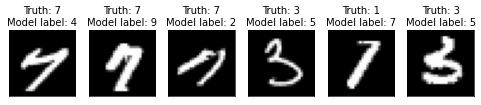

Epoch [62/100] training time: 138.18s at a learning rate of 0.0005 with a final loss of 0.005
Epoch [63/100] training time: 140.03s at a learning rate of 0.0005 with a final loss of 0.007
Epoch [64/100] training time: 141.91s at a learning rate of 0.0005 with a final loss of 0.021
Epoch [65/100] training time: 143.77s at a learning rate of 0.0005 with a final loss of 0.011
Epoch [66/100] training time: 145.61s at a learning rate of 0.0005 with a final loss of 0.02
Epoch [67/100] training time: 147.51s at a learning rate of 0.0005 with a final loss of 0.003
Epoch [68/100] training time: 149.38s at a learning rate of 0.0005 with a final loss of 0.004
Epoch [69/100] training time: 151.24s at a learning rate of 0.0005 with a final loss of 0.004
Epoch [70/100] training time: 153.15s at a learning rate of 0.0005 with a final loss of 0.014
Epoch [71/100] training time: 155.02s at a learning rate of 0.0005 with a final loss of 0.004
In the test set 99.6% were correctly classified.


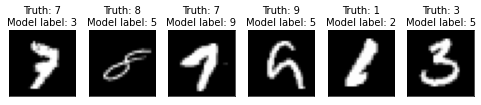

Epoch [72/100] training time: 158.18s at a learning rate of 0.0005 with a final loss of 0.006
Epoch [73/100] training time: 160.03s at a learning rate of 0.0005 with a final loss of 0.012
Epoch [74/100] training time: 161.87s at a learning rate of 0.0005 with a final loss of 0.007
Epoch [75/100] training time: 163.73s at a learning rate of 0.0005 with a final loss of 0.012
Epoch [76/100] training time: 165.58s at a learning rate of 0.0005 with a final loss of 0.001
Epoch [77/100] training time: 167.42s at a learning rate of 0.0005 with a final loss of 0.018
Epoch [78/100] training time: 169.24s at a learning rate of 0.0005 with a final loss of 0.001
Epoch [79/100] training time: 171.09s at a learning rate of 0.0005 with a final loss of 0.002
Epoch [80/100] training time: 172.93s at a learning rate of 0.0005 with a final loss of 0.004
Epoch [81/100] training time: 174.83s at a learning rate of 0.0005 with a final loss of 0.002
In the test set 99.6% were correctly classified.


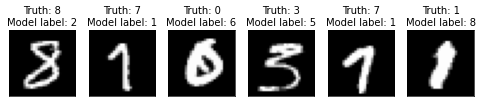

Epoch [82/100] training time: 178.18s at a learning rate of 0.0005 with a final loss of 0.004
Epoch [83/100] training time: 180.05s at a learning rate of 0.0005 with a final loss of 0.015
Epoch [84/100] training time: 181.91s at a learning rate of 0.0005 with a final loss of 0.006
Epoch [85/100] training time: 183.78s at a learning rate of 0.0005 with a final loss of 0.017
Epoch [86/100] training time: 185.6s at a learning rate of 0.0005 with a final loss of 0.006
Epoch [87/100] training time: 187.44s at a learning rate of 0.0005 with a final loss of 0.001
Epoch [88/100] training time: 189.31s at a learning rate of 0.0005 with a final loss of 0.011
Epoch [89/100] training time: 191.15s at a learning rate of 0.0005 with a final loss of 0.001
Epoch [90/100] training time: 193.02s at a learning rate of 0.0005 with a final loss of 0.0
Epoch [91/100] training time: 194.88s at a learning rate of 0.0005 with a final loss of 0.043
In the test set 99.6% were correctly classified.


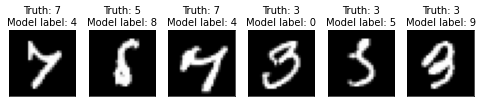

Epoch [92/100] training time: 198.09s at a learning rate of 0.0005 with a final loss of 0.008
Epoch [93/100] training time: 199.94s at a learning rate of 0.0005 with a final loss of 0.002
Epoch [94/100] training time: 201.8s at a learning rate of 0.0005 with a final loss of 0.002
Epoch [95/100] training time: 203.67s at a learning rate of 0.0005 with a final loss of 0.009
Epoch [96/100] training time: 205.53s at a learning rate of 0.0005 with a final loss of 0.007
Epoch [97/100] training time: 207.41s at a learning rate of 0.0005 with a final loss of 0.001
Epoch [98/100] training time: 209.29s at a learning rate of 0.0005 with a final loss of 0.002
Epoch [99/100] training time: 211.18s at a learning rate of 0.0005 with a final loss of 0.024
Epoch [100/100] training time: 213.06s at a learning rate of 0.0005 with a final loss of 0.004
Final loss value of: 0.004
Model saved as "/content/drive/MyDrive/Colab Notebooks/train_classifier/classifier.pt"


In [626]:
if loadModel:
  model,optimiser = loadModel(model,optimiser,modelPath)
            
model, losses, optimiser, iterNumbers, percentCorrect = run_backpropogation_optimisation(device,model,data[0:nTrain,:,:,:],labels[0:nTrain,:],epochs,learningRate,
                                                                                         iterNumbers,printSubsets,losses,nBatch,loss_function,dataloader,percentCorrect,True)
print('Final loss value of: ' + str(round(losses[-1],3)))


if saveModel:
    torch.save({
        'epoch': iterNumbers[-1],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser.state_dict(),
        'loss': losses[-1],
            }, modelPath)
    print('Model saved as "' + modelPath + '"')

In the test set 99.7% were correctly classified.


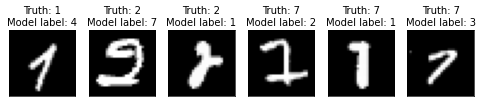

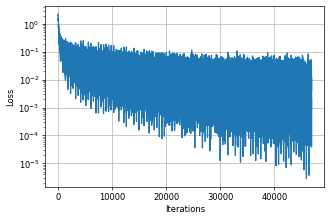

In [643]:
run_test_set(model,testFiles,plotNumberIncorrectSubset,nTest,device,True)
mpl.rcParams['figure.dpi'] = 60
plt.figure()
ax = plt.gca()
plt.plot(losses)
plt.grid()
plt.xlabel('Iterations')
plt.ylabel('Loss')
ax.set_yscale('log')
plt.show()


0.0005


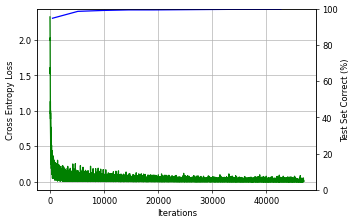

In [634]:
mpl.rcParams['figure.dpi'] = 60

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(iterNumbers[1:], losses, 'g-')
ax2.plot([x[0] for x in percentCorrect], [x[1] for x in percentCorrect], 'b-')
ax1.grid()
ax2.set_ylim([0,100])
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Cross Entropy Loss')
ax2.set_ylabel('Test Set Correct (%)')
print(learningRate)